In [2]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read CSV into dataframe and preview
file_csv = "data/classify_reduced.csv"
classify_df = pd.read_csv(file_csv, encoding="ISO-8859-1")
classify_df.head()

,IsHoliday,Weekly_Sales
0,0,18689.54
1,0,19050.66
2,1,20911.25
3,0,25293.49
4,0,33305.92


In [4]:
classify_df.describe()

,IsHoliday,Weekly_Sales
count,150681.000000,150681.000000
mean,0.079254,16215.489727
std,0.270135,23264.066000
min,0.000000,-1699.000000
25%,0.000000,2021.860000
50%,0.000000,7565.370000
75%,0.000000,20466.720000
max,1.000000,649770.180000


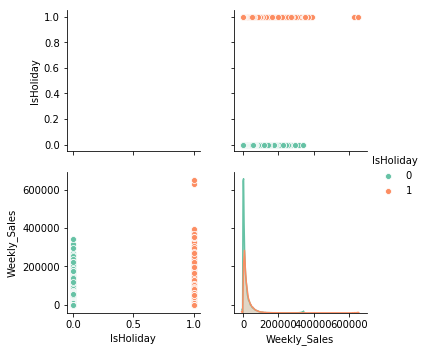

In [5]:
sns.pairplot(classify_df,hue='IsHoliday',palette='Set2')

In [6]:
print(classify_df.dtypes)

IsHoliday         int64
Weekly_Sales    float64
dtype: object


In [7]:
len(classify_df)

150681

In [8]:
# Define features
X = classify_df.loc[:, classify_df.columns != 'IsHoliday']
X.head()

,Weekly_Sales
0,18689.54
1,19050.66
2,20911.25
3,25293.49
4,33305.92


In [9]:
# Define target
y = classify_df['IsHoliday'].to_frame()
y.head()

,IsHoliday
0,0
1,0
2,1
3,0
4,0


In [10]:
# Count of target values
y['IsHoliday'].value_counts()

0    138739
1     11942
Name: IsHoliday, dtype: int64

In [11]:
# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

In [12]:
# 80/20 training and test split. Incorporate stratification to retain
# class distribution within the training and test sets.

X_train, X_test, y_train, y_test = train_test_split(
    X_standard,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42    
)

In [13]:
#  Train a logistic regression classifier on the training set using the default hyperparameter
# and evaluate its performance on the test set. 
# Classes are imbalanced---use F1 score performance metric.

classify = LogisticRegression()
classify.fit(X_train, y_train)
y_pred = classify.predict(X_test)
metrics.f1_score(y_test, y_pred)

0.0

In [14]:
# Confirm this performance holds for other splits, tune the regularization hyperparameter. 
# Utilize nested cross-validation

param_grid = [{'C': np.logspace(-3, 3, 10)}]

grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

scores = cross_val_score(
    estimator=grid_search,
    X=X_standard,
    y=y,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    scoring='f1',
    n_jobs=-1
)

In [15]:
scores

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
scores.mean()

0.0

In [17]:
# Perform grid search to identify the optimal regularization hyperparameter.

grid_search.fit(X_standard, y)
grid_search.best_params_

{'C': 0.001}

In [18]:
# train the final model
final_classify = LogisticRegression(C=0.1)
final_classify.fit(X_standard, y);

In [19]:
# report the five features that are most strongly correlated with class
feature_ranks = pd.DataFrame(final_classify.coef_, index=['parameter value'])
feature_ranks.columns = X.columns

# Strongest five positive
feature_ranks.sort_values('parameter value', axis=1, ascending=False).T.head()

,parameter value
Weekly_Sales,0.060777


In [20]:
# Strongest five negative
feature_ranks.sort_values('parameter value', axis=1, ascending=True).T.head()

,parameter value
Weekly_Sales,0.060777


In [21]:
print(confusion_matrix(y_test,y_pred))

[[27749     0]
 [ 2388     0]]


In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27749
           1       0.00      0.00      0.00      2388

   micro avg       0.92      0.92      0.92     30137
   macro avg       0.46      0.50      0.48     30137
weighted avg       0.85      0.92      0.88     30137



In [23]:
confusion_df = pd.DataFrame(data=confusion_matrix(y_test,y_pred),columns=['Predicted No', 'Predicted Yes'])
print(confusion_df)

   Predicted No  Predicted Yes
0         27749              0
1          2388              0


In [24]:
MAE = mean_absolute_error(y_test,y_pred)
print(MAE)

0.07923814580084282
